In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array
    # mechanical_stress:  jax.Array

In [29]:
N_DIM = 2
N_CHEM = 3
N_HIDDEN = 16

N = 120
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,1)).at[0].set(1),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    # mechanical_stress= np.zeros(shape=(N,1)),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [30]:
key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5),

        jxm.cell.sensing.LocalChemicalGradients(),

        # jxm.cell.sensing.LocalMechanicalStress(mech_potential),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius'],# 'mechanical_stress'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=.8,
                            ),
    ])

# REINFORCE Loss

In [31]:
from functools import partial

In [32]:
@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, BATCH_SIZE=1, GAMMA=.9, LAMBDA=.001):

    subkeys = jax.random.split(key, BATCH_SIZE)
    subkeys = np.asarray(subkeys)

    vsim = jax.vmap(partial(jxm.simulate, history=True), (None, None, 0, None))
    trajectory, logp = vsim(model, istate, subkeys, n_steps)


    istate = jtu.tree_map(lambda x: np.repeat(x[None,None,:,:],BATCH_SIZE,0), istate)

    trajectory = jtu.tree_map(lambda *v: np.concatenate(v,1), *[istate, trajectory])


    cost = jax.vmap(cost_fn)(trajectory)


    #discounted costs
    def _returns_rec(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    
    # cost = jax.vmap(_returns_rec)(cost)

    # cost = (cost-cost.mean(-1, keepdims=True))/(cost.std(-1, keepdims=True)+1e-8)


    #no - sign because we assume a cost instead of a reward
    loss = np.sum(jax.lax.stop_gradient(cost)*logp)


    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg

## Cost Functions

In [33]:
def mean_square_coord(trajectory, *, realign=True):

    if realign:

        @jax.vmap
        def _realign(pos):
            _, P = np.linalg.eigh(np.cov(pos.T))
            return pos @ P[:,::-1]

        pos = _realign(trajectory.position)

    else:
        pos = trajectory.position


    ssq = ((pos[:,:,1] * trajectory.celltype.sum(-1))**2).sum(-1) 
    ns = trajectory.celltype.sum(-1).sum(-1)

    symm = .1*np.abs((pos[:,:,0] * trajectory.celltype.sum(-1)).sum(-1))

    cost = np.diff(ssq/ns + symm/ns)

    return cost

# Training

In [34]:
import optax
from tqdm import trange
from functools import partial

In [49]:
EPOCHS = 30
BATCH_SIZE = 4


COST_FN = mean_square_coord
LAMBDA=0.


opt_model = model


optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, subkey = jax.random.split(key)

rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        # g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, opt_model)
        opt_model = eqx.apply_updates(opt_model, updates)

        key, subkey = jax.random.split(key)

        rl, g = eqx.filter_value_and_grad(reinforce_loss)(opt_model, istate, cost_fn=mean_square_coord, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

        l = COST_FN(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


        rlosses.append(float(rl))
        losses.append(float(l))
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: 5.620: 100%|██████████████████████████████| 30/30 [00:21<00:00,  1.43it/s]


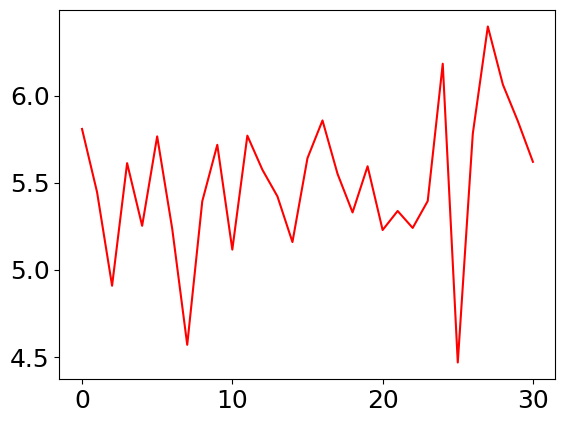

In [50]:
plt.plot(losses, 'r')

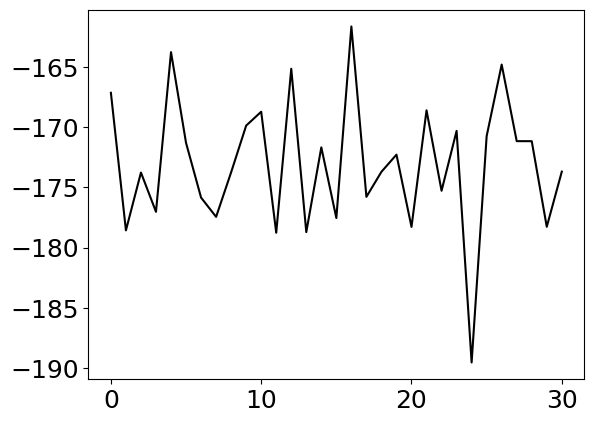

In [51]:
plt.plot(rlosses, 'k')

In [52]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_model, istate, subkey, N_ADD)

In [53]:
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress

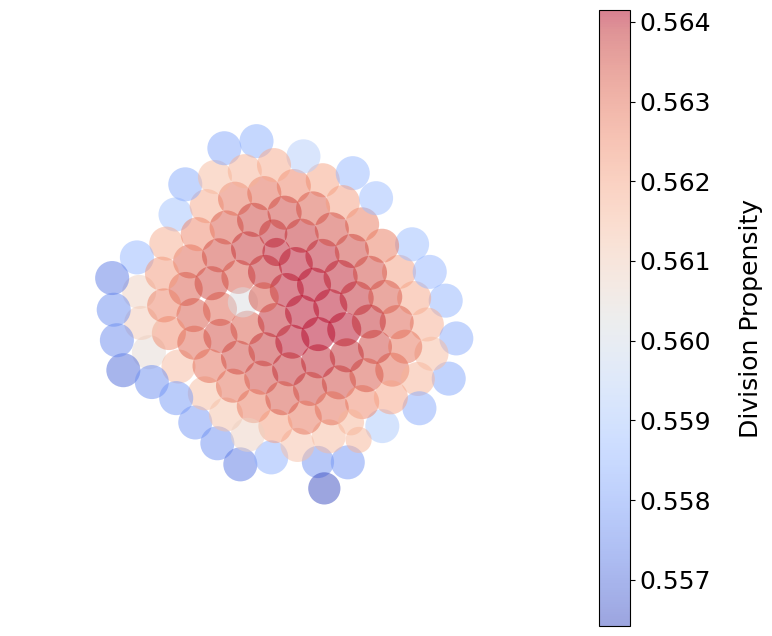

In [54]:
draw_circles_divrate(s);

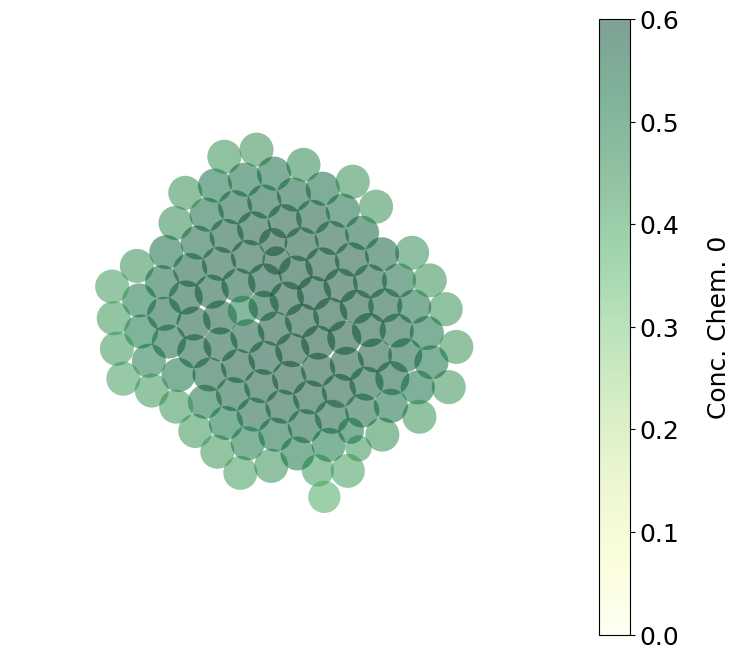

In [55]:
draw_circles_chem(s, 0);

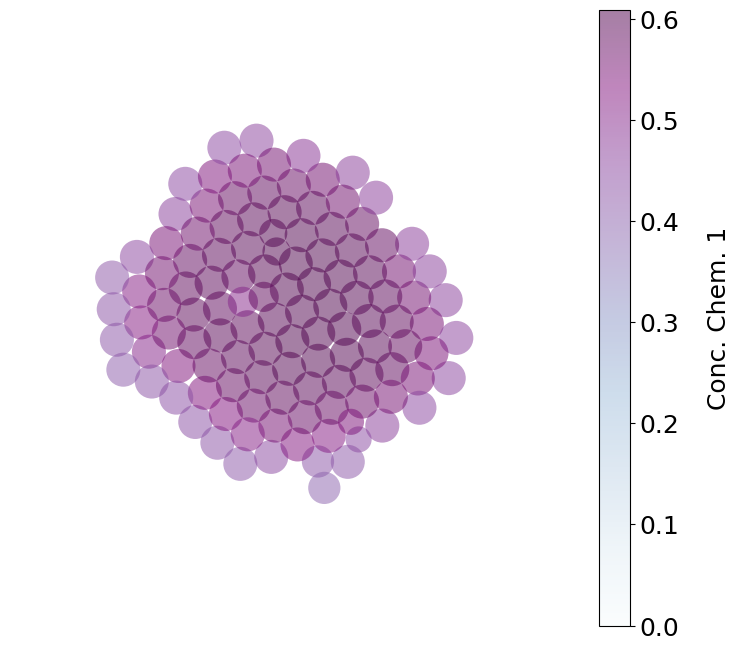

In [56]:
draw_circles_chem(s, 1);

# Visualizations

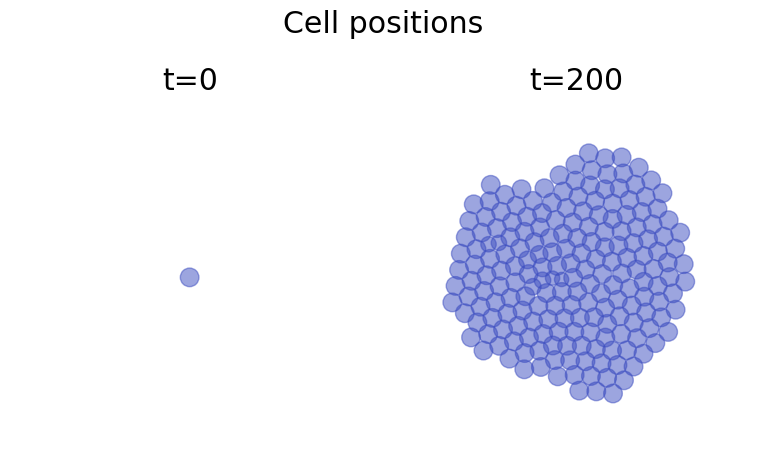

In [10]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Cell positions', y=.8)


jxm.visualization.draw_circles_ctype(istate, ax=axs[0])
axs[0].set_title('t=0')

jxm.visualization.draw_circles_ctype(fstate, ax=axs[1])
axs[1].set_title(f't={N}');


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

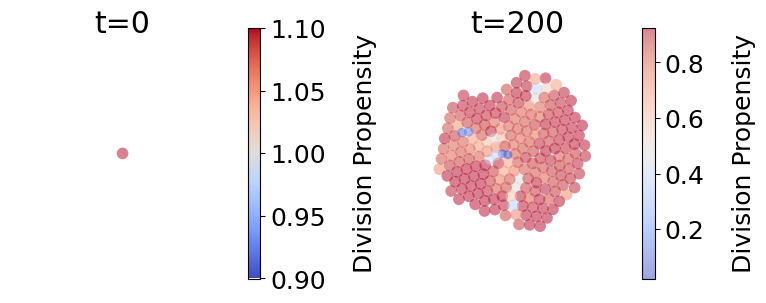

In [11]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_divrate(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_divrate(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

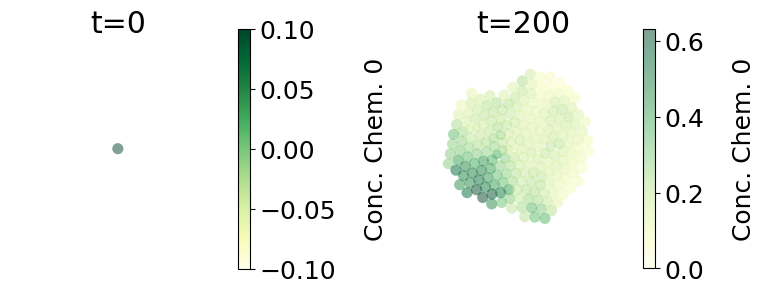

In [12]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=0, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=0, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

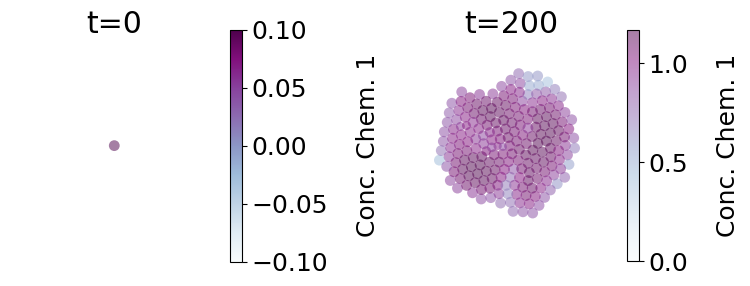

In [13]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_chem(istate, chem=1, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_chem(fstate, chem=1, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()

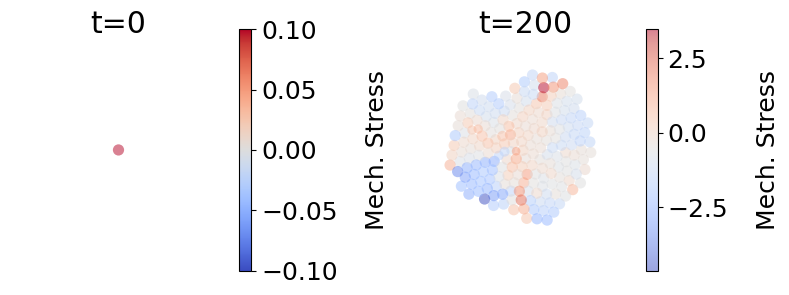

In [14]:
fig, axs = plt.subplots(1,2)


jxm.visualization.draw_circles_stress(istate, ax=axs[0])
axs[0].set_title('t=0')


jxm.visualization.draw_circles_stress(fstate, ax=axs[1])
axs[1].set_title(f't={N}')


#set same axis limits
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())



# background to white
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.)
fig.tight_layout()